# Differential analyses (z-score approach)

In [1]:
import os
import pandas as pd
import numpy as np
import anndata as ann

import spatialdm as sdm
from spatialdm.datasets import dataset
import spatialdm.plottings as pl
print("SpatailDM version: %s" %sdm.__version__)

SpatailDM version: 0.0.2


## z-score selection in batch

In [2]:
data=["A1","A2","A3","A4","A6","A7","A8","A9"]

The intestine dataset from Corbett, et al. was publicly available on [STAR-FINDer](https://simmonslab.shinyapps.io/FetalAtlasDataPortal/), from which
we obtained raw counts and spatial coordinates, and log-transformed to normalize on the spot-level. 
Rawcounts (`.raw`), logcounts (`.X`), cell types (`.obs`), and spatial coordinates (`.obsm['spatial']`) have been included in the corresponding anndata object which can be loaded directly in SpatialDM Python package.

In [3]:
A1_adata = dataset.A1()
A2_adata = dataset.A2()
A3_adata = dataset.A3()
A4_adata = dataset.A4()
A6_adata = dataset.A6()
A7_adata = dataset.A7()
A8_adata = dataset.A8()
A9_adata = dataset.A9()

createVar = locals()
for d in data:
    adata = locals()[d+'_adata']
    createVar[d] = sdm.SpatialDM(pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names),
               pd.DataFrame(adata.raw.X, index=adata.obs_names, columns=adata.var_names),
               adata.obsm['spatial'])
    print(d+' done!')

A1 done!
A2 done!
A3 done!
A4 done!
A6 done!
A7 done!
A8 done!
A9 done!


<div class="alert alert-info">

**Note**
    
The dataset includes: \
    1) 2 adult colon samples from the same donor A, with IBD or colon cancer (A1, A2); \
    2) 2 replicates of 12-PCW TI from fetus donor D (A6, A7); \
    3) 3 12-PCW colon samples, 2 replicates from donor D (A8, A9), another from donor B (A3); \
    4) 1 19-PCW colon sample from donor C (A4).
    
</div>  

In [4]:
samples = [A1,A2,A3,A4,A6,A7,A8,A9]

Considering the scale of the spatial coordinates and spot-spot distance of 100 micrometers, `l` will be set to 75 here. 
The parameters here should be determined to match the context of CCC.

In [5]:
for sample in samples:
    sample.weight_matrix(l=75, cutoff=0.2, single_cell=False) # weight_matrix by rbf kernel

    sample.extract_lr('human', min_cell=10)      # find overlapping LRs from CellChatDB

    sample.spatialdm_global(method='z-score',nproc=1)     # global Moran selection

    sample.sig_pairs(method='z-score', fdr=True, threshold=0.1)     # select significant pairs

    sample.spatialdm_local(method='z-score', select_num=None, nproc=1)     # local spot selection
    sample.sig_spots(method='z-score', fdr=False, threshold=0.1)     # significant local spots

filtered non-expressed LR pairs. 

Save selection results in batch

In [6]:
# save output
# data_dir='output'
# for sample,d in zip(samples, data):
#     sample.save_spataildm(os.path.join(data_dir, d))

## differential test on 6 colon samples (adult vs. fetus)

In [7]:
from spatialdm.diff_utils import *

First step is to concatenate all selection results, resulting in a `p_df` storing p-values across each sample before fdr correction, a `tf_df` indicating whether each pair is selected in each sample, and a `zscore_df` which stores z-scores. These will be essential for the differential analyses later.

In [8]:
concat=concat_obj(samples, data, 'human', 'z-score', fdr=False)

In [9]:
concat.p_df.head()

,A1,A2,A3,A4,A6,A7,A8,A9
TGFB1_TGFBR1_TGFBR2,9.480100e-12,4.969504e-08,0.048548,1.261308e-04,1.279986e-04,5.441931e-05,0.446930,2.327897e-04
TGFB3_TGFBR1_TGFBR2,1.162158e-02,3.217188e-04,0.000015,2.506158e-19,5.323057e-10,1.487019e-08,0.040947,3.438959e-09
TGFB1_ACVR1B_TGFBR2,1.214133e-06,3.377207e-03,0.560708,5.700042e-02,9.175232e-03,1.993415e-02,0.821447,2.194205e-01
TGFB1_ACVR1C_TGFBR2,7.297770e-09,2.447690e-06,0.074222,1.762631e-03,5.056038e-03,2.381453e-02,0.605893,1.133950e-01
TGFB3_ACVR1B_TGFBR2,4.174944e-02,1.271743e-03,0.063777,1.328844e-06,1.159537e-02,1.110680e-02,0.267259,2.819634e-07


In [10]:
concat.tf_df.head()

,A1,A2,A3,A4,A6,A7,A8,A9
TGFB1_TGFBR1_TGFBR2,True,True,False,True,True,True,False,True
TGFB3_TGFBR1_TGFBR2,True,True,True,True,True,True,False,True
TGFB1_ACVR1B_TGFBR2,True,True,False,False,True,True,False,False
TGFB1_ACVR1C_TGFBR2,True,True,False,True,True,True,False,False
TGFB3_ACVR1B_TGFBR2,False,True,False,True,True,True,False,True


In [11]:
concat.zscore_df.head()

,A1,A2,A3,A4,A6,A7,A8,A9
TGFB1_TGFBR1_TGFBR2,6.713814,5.327835,1.659098,3.659953,3.656184,3.869993,0.133422,3.499816
TGFB3_TGFBR1_TGFBR2,2.269414,3.412611,4.178049,8.911993,6.099409,5.542958,1.739802,5.793879
TGFB1_ACVR1B_TGFBR2,4.714062,2.708716,-0.152764,1.580463,2.358470,2.055111,-0.920894,0.774152
TGFB1_ACVR1C_TGFBR2,5.666251,4.569222,1.445050,2.917786,2.571973,1.980663,-0.268629,1.208669
TGFB3_ACVR1B_TGFBR2,1.730736,3.018120,1.523822,4.695643,2.270278,2.286695,0.621123,5.003178


Whole-interactome clustering revealed the dendrogram relationships that are close to the sample kinship

/home/yoyo/miniconda2/envs/CC/lib/python3.9/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


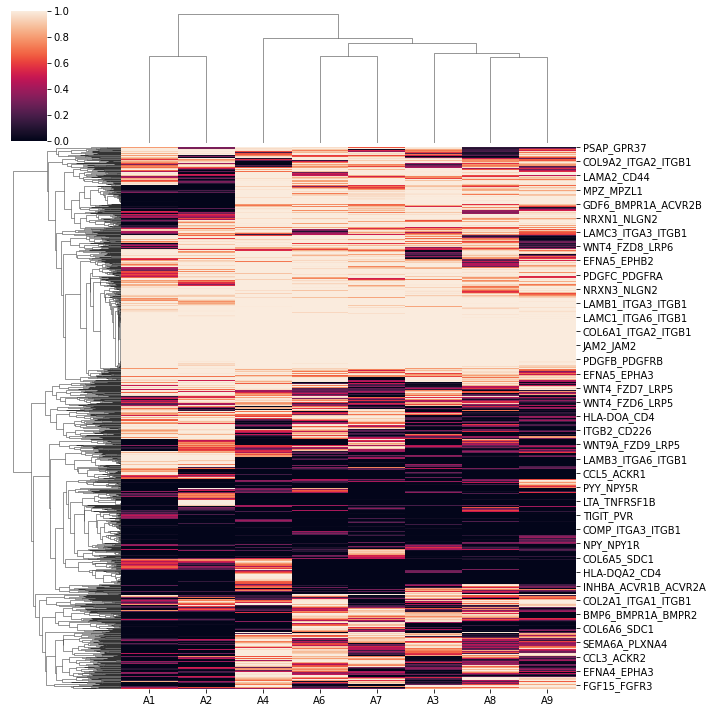

In [12]:
import seaborn as sns
sns.clustermap(1-concat.p_df)

Next, we subset the 6 colon samples (2 adult vs. 4 fetus for differential analyses.

Use 1 and 0 to label different conditions.

<div class="alert alert-info">

**Note**
z-score differential testing will also support differential test among 3 or more conditions, provided with sufficient samples.
</div>  

In [13]:
conditions = np.hstack((np.repeat([1],2), np.repeat([0],4)))
subset = ['A1', 'A2', 'A3', 'A4', 'A8', 'A9']

By `differential_test`, likelihood ratio test will be performed, and the differential p-values are stored in `.p_val`, corresponding fdr values in `.diff_fdr`, and difference in average zscores in `.diff`.

In [14]:
concat.differential_test(subset, conditions)

/home/yoyo/miniconda2/envs/CC/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/yoyo/miniconda2/envs/CC/lib/python3.9/site-packages/spatialdm/diff_utils.py:106: RuntimeWarning: invalid value encountered in double_scalars
  LR_statistic[i] = -2 * (reduced_ll - full_ll)


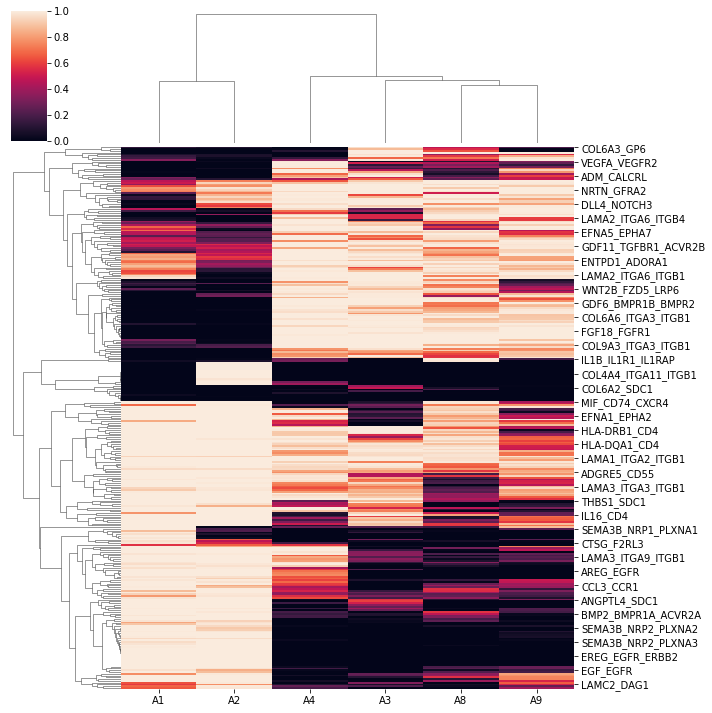

In [15]:
pl.differential_dendrogram(concat)

Later, we can focus on differential pairs within 2 contrasting conditions. By default, pairs with z-score difference greater than 30% quantile and a corrected differential significance (`.diff_fdr`) smaller than 0.1 are selected, while different parameters can be applied in `diff_quantile1`, `diff_quantile2`, and `fdr_co`, respectively.

In [16]:
concat.group_differential_pairs('adult', 'fetus')

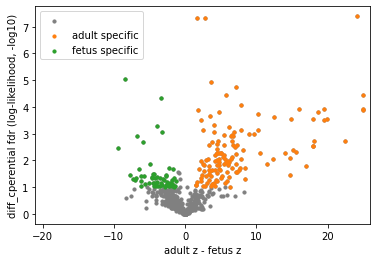

In [17]:
pl.differential_volcano(concat, legend=['adult specific', 'fetus specific'])

`differential_volcano` allows easy check for target pair(s) in whether they are differential among conditions and in which condition it's specific.

<div class="alert alert-info">

**Note**
    
CEACAM1_CEACAM5 is sparsely identified in A3 in addition to two adult slices, but still considered adult-specific by differential analyses. \
NRG4 was found in human breast milk, and its oral supplementation can protect against inflammation in the intestine. \
PLG_F2RL1 is sparsely and exclusively identified in fetal samples with consistent cell type enrichment. \
BMP2 was reported to be expressed by, and act on mature colon epithelial cells from RT-PCR and immunoblotting. \
Please refer to our manuscript for more discussions.
</div>  

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

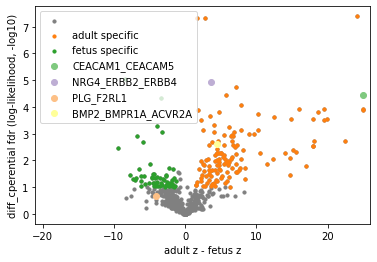

In [18]:
pl.differential_volcano(concat, pairs=['CEACAM1_CEACAM5', 'NRG4_ERBB2_ERBB4', 'PLG_F2RL1','BMP2_BMPR1A_ACVR2A'], 
        legend=['adult specific', 'fetus specific'], )

It will also be interpretable to analyze condition-specific pairs on a pathway level. \
Here we identified an inflammatory microenvironment in adult colon samples and more development-related signatures in the fetal colon samples.

In [19]:
sdm.compute_pathway(concat, ls=concat.adult_specific.values, path_name = 'adult_specific_pathways')
sdm.compute_pathway(concat, ls=concat.fetus_specific.values, path_name = 'fetus_specific_pathways')

In [20]:
# remove pathways with only one hit
concat.path_summary['fetus_specific_pathways']['counts'] = \
    concat.path_summary['fetus_specific_pathways']['counts'][concat.path_summary['fetus_specific_pathways']['counts']>1]

concat.path_summary['adult_specific_pathways']['counts'] = \
    concat.path_summary['adult_specific_pathways']['counts'][concat.path_summary['adult_specific_pathways']['counts']>1]

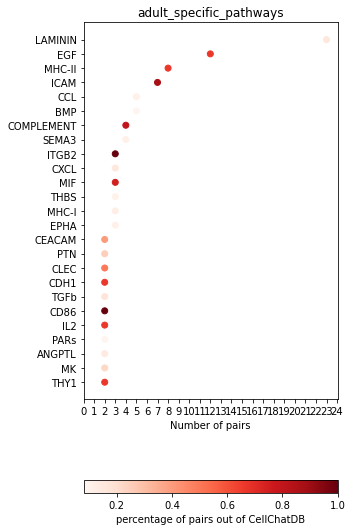

In [21]:
pl.dot_path(concat, 'adult_specific_pathways', figsize=(5,8))

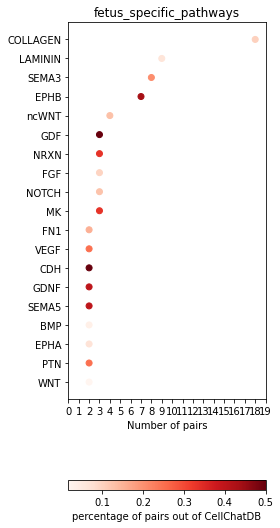

In [22]:
pl.dot_path(concat, 'fetus_specific_pathways', figsize=(4,8))

## Cross-replicate consistency 

Thanks to the multi-replicate setting, we could validate the consistency between biological / technical replicates

In [23]:
I_df = pd.DataFrame(pd.Series(sample.global_I, index=sample.global_res.index) for sample in samples)

In [24]:
I_df = I_df.transpose()

In [25]:
I_df.columns = data

Extract the Global R from each replicate.

Text(0.5, 1.0, "Moran's I between replicates")

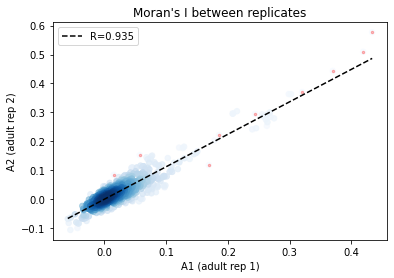

In [26]:
from hilearn import *
_df = I_df.loc[:, ['A1', 'A2']].dropna()
corr_plot(_df.A1.values, _df.A2.values)
plt.xlabel('A1 (adult rep 1)')
plt.ylabel('A2 (adult rep 2)')
plt.title('Moran\'s I between replicates')

Text(0.5, 1.0, "Moran's I between replicates")

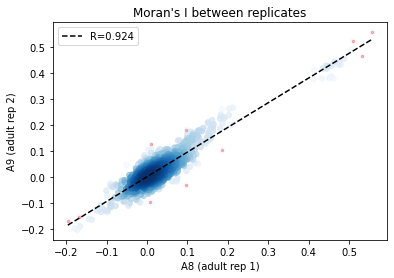

In [27]:
_df = I_df.loc[:, ['A8', 'A9']].dropna()
corr_plot(_df.A8.values, _df.A9.values)
plt.xlabel('A8 (adult rep 1)')
plt.ylabel('A9 (adult rep 2)')
plt.title('Moran\'s I between replicates')

Text(0.5, 1.0, "Moran's I between non-biological replicates")

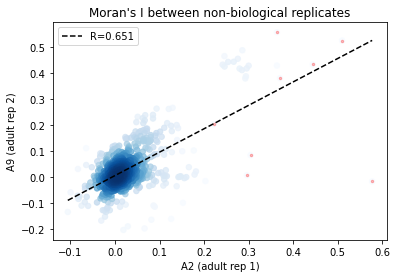

In [28]:
_df = I_df.loc[:, ['A2', 'A9']].dropna()
corr_plot(_df.A2.values, _df.A9.values)
plt.xlabel('A2 (adult rep 1)')
plt.ylabel('A9 (adult rep 2)')
plt.title('Moran\'s I between non-biological replicates')

From the above results, Global R is consistent between replicates.

We can also assess the local selection consistency by comparing the cell type compositions of selected spots

In [29]:
fetus_celltypes = A3_adata.obs.columns
PLG_df = pd.DataFrame(fetus_celltypes, index=fetus_celltypes)

PLG_F2RL1 is sparsely detected in fetus samples, it will be interesting to see whether such selections are consistent.

In [30]:
pair='PLG_F2RL1'
for d,sample in zip(data,samples):
    sample.celltype = locals()['{}_adata'.format(d)].obs
    if pair in sample.local_z_p.index:
        ct=sample.celltype[sample.local_z_p.loc[pair].values<0.1].sum(0).sort_values(ascending=False)
        ct=ct[ct>0]
        PLG_df['{}'.format(d)]=ct
    else:
        PLG_df['{}'.format(d)] = 0

Group spot weights by selecte cell type vs other cell types

In [31]:
PLG_df.pop(0)
other=PLG_df.loc[~PLG_df.index.isin(['Distal Enterocytes','Distal Mature Enterocytes'])].sum(0)
df =pd.concat((PLG_df.loc[PLG_df.index.isin(['Distal Enterocytes','Distal Mature Enterocytes'])],
    pd.DataFrame(other, columns=['other cell types']).transpose()))

df = df.transpose()
df['sample']=df.index

PLG_F2RL1 is enriched in Enterocytes in 12-PCW colons, but not found in 19-PCW and adult samples.
The two 12-PCW TI samples also have consistent PLG_F2RL1 enrichment, but the signaling celltypes are different from colon samples.

[Text(0, 0, 'A1'),
 Text(1, 0, 'A2'),
 Text(2, 0, 'A3'),
 Text(3, 0, 'A4'),
 Text(4, 0, 'A6'),
 Text(5, 0, 'A7'),
 Text(6, 0, 'A8'),
 Text(7, 0, 'A9')]

<Figure size 432x288 with 0 Axes>

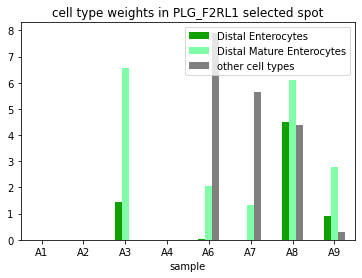

In [32]:
plt.figure()
ax=df.sort_index().plot(x='sample',
        kind='bar',
        stacked=False,
        title='cell type weights in PLG_F2RL1 selected spot', 
        color={'Distal Mature Enterocytes': [0.5       , 1.        , 0.65808859, 1.        ],
              'Distal Enterocytes': [0.06331813, 0.62857143, 0.        , 1.        ],
#                'neuron':[0.99848342, 0.875     , 0.99522066, 1.        ],
              'other cell types': 'grey'})
ax.set_xticklabels(df.sort_index().index, rotation=0)